## Summarizing Chatbot w/f with Memory

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage
from langgraph.graph.message import MessagesState, RemoveMessage
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.4)

class State(MessagesState):
    summary: str

In [3]:
def chat_model(state:State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of the Conversation Earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)

    return {"messages": response}

In [4]:
def summarize_conversation(state:State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This Summary of the Conversation is to date: {summary} \n\n",
            "Extend the Summary by taking into account the new messages above:"
        )
    else:
        summary_message = "create a summary of the conversation above"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]

    response = llm.invoke(messages)

    deleted_messages = [RemoveMessage(msg.id) for msg in state["messages"][:-2]]

    return {
        "messages": deleted_messages,
        "summary": response.content
    }

In [5]:

def should_continue(state: State):
    """Return the Next Node to execute"""
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"
    
    return END


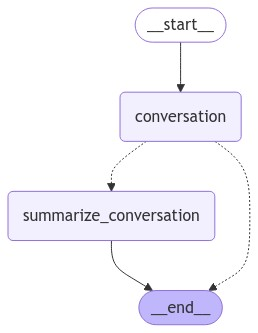

In [6]:
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(State)

workflow.add_node("conversation", chat_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START,"conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
config = {"configurable" : {"thread_id" : "1"}}

input_message = HumanMessage(content="Hi, this is Hijabie")
out_put = graph.invoke({"messages" : [input_message]}, config)
for m in out_put["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What is my Name?")
out_put = graph.invoke({"messages" : [input_message]}, config)
for m in out_put["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="tell me about white Wolf?")
out_put = graph.invoke({"messages" : [input_message]}, config)
for m in out_put["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Hijabie! How can I assist you today?
================================== Ai Message ==================================

Your name is Hijabie. How can I help you today?
================================== Ai Message ==================================

The term "white wolf" can refer to several different concepts, depending on the context. Here are a few interpretations:

1. **Animal**: The white wolf is often associated with the Arctic wolf (Canis lupus arctos), which has a thick white coat that helps it blend into its snowy environment. These wolves are found primarily in the Arctic regions of North America and Greenland. They are social animals that live in packs and are known for their hunting skills and adaptability to harsh climates.

2. **Symbolism**: In many cultures, wolves, including white wolves, are seen as symbols of loyalty, guardianship, and intelligence. The color white often symbolizes pur

In [8]:
graph.get_state(config).values.get("summary","")

''

In [9]:
input_message = HumanMessage(content="History of Wolf in Turkish Empire?")
out_put = graph.invoke({"messages" : [input_message]}, config)
for m in out_put["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

The wolf holds a significant place in the history and culture of the Turkish peoples, particularly during the time of the Turkish Empire and its predecessors. Here are some key points about the role of wolves in Turkish history and mythology:

1. **Mythological Significance**: In Turkic mythology, the wolf is often considered a sacred animal. The "Grey Wolf" (Kurt) is a prominent symbol of strength, courage, and loyalty. According to legend, the mythical ancestor of the Turks, Asena, was a she-wolf who helped a young boy survive and later gave birth to a line of descendants who became the Turks. This story emphasizes the wolf's role as a protector and a symbol of the Turkic identity.

2. **Cultural Symbol**: The wolf is a recurring motif in Turkic art, folklore, and literature. It represents not only physical strength but also spiritual guidance and the connection to nature. The wolf's image is often used

In [10]:
graph.get_state(config).values.get("summary","")

'In our conversation, you first introduced yourself as Hijabie and then asked about the "white wolf." I provided several interpretations of the term, including its reference to the Arctic wolf, its symbolic significance in various cultures, its representation in literature and media (notably in "The Witcher" series), and its association with White Wolf Publishing, known for tabletop role-playing games.\n\nYou then inquired about the history of the wolf in the Turkish Empire. I explained that the wolf, particularly the Grey Wolf, holds significant mythological and cultural importance for the Turkic peoples. It is associated with strength, courage, and loyalty, with legends like that of Asena, the she-wolf who is considered an ancestor of the Turks. The wolf has been used as a military symbol and continues to represent national pride in modern Turkey, particularly among nationalist groups. Additionally, I mentioned the presence of wolves in Turkish folklore, where they are often depicted